# Домашнее задание

### Д/з из четырех пунктов:
* Улучшение `fit_generator`
* Сравнение двух ReLU (разные активации)
* Испорченный батч-норм 
* "Сырые" данные. 

### Что нужно сделать
* Следовать инструкциям в каждом из пунктов.
* Результатами вашей работы будет ноутбук с доработанным кодом + архив с директорией с логами `tensorboard` `logs/`, в который вы запишите результаты экспериментов. Подробности в инструкциях ниже.
* Можно и нужно пользоваться кодом из файла `utils`, **но** весь код модифицируйте, пожалуйста, в ноутбуках! Так мне будет проще проверять.

**Загрузка tensorboard в ноутбук**

Можете попробовать использовать его так на свой страх и риск :)

In [1]:
#запуск TensorBoard из командной строки
# %load_ext tensorboard
# %tensorboard --logdir logs

**Импорты**

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from typing import Callable

### Импорт слоев для д/з

In [3]:
from utils import BatchNormFlawed, Dense, DenseSmart, Sequential, MNISTSequence

### Загрузка данных

> Здесь ничего менять не нужно

In [4]:
(X_tr, y_tr), (X_test, y_test) = keras.datasets.mnist.load_data()

In [5]:
train_seq = MNISTSequence(X_tr, y_tr, 128)
test_seq = MNISTSequence(X_test, y_test, 128)

**Очистка данных**

In [57]:
!rm -rf logs/*

In [58]:
!mkdir -p logs

In [59]:
keras.backend.clear_session()

## 1. Улучшение fit_generator

Улучшите метод `fit_generator` так, чтобы он:
* Записывал значения градиентов для всех переменных при помощи `tf.summary.histogram` 
* Записывал значения ошибки и метрики на валидации с помощью `tf.summary.scalar`

Затем сделайте monkey patch класса sequential обновленным методом (следующая ячейка за методом `fit_generator`).

In [32]:
def fit_generator(self, train_seq, eval_seq, epoch, loss, optimizer, writer=None):
    history = dict(train=list(), val=list())

    train_loss_results = list()
    val_loss_results = list()

    train_accuracy_results = list()
    val_accuracy_results = list()

    step = 0
    for e in range(epoch):
        p = tf.keras.metrics.Mean()
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_loss_avg_val = tf.keras.metrics.Mean()

        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        epoch_accuracy_val = tf.keras.metrics.SparseCategoricalAccuracy()

        for x, y in train_seq:
            with tf.GradientTape() as tape:
                """
                Обратите внимание! Если записывать гистограмму каждый шаг,
                обучение будет идти очень медленно. Поэтому записываем данные 
                каждый i-й шаг.
                """
                if step % 50 == 0:
                    prediction = self._forward(x, writer, step)
                else:
                    prediction = self._forward(x)
                loss_value = loss(y, prediction)
                     
            ###############################################################
            #                                                             #
            # Добавьте запись градиентов в гистограммы                    #
            #                                                             #
            ###############################################################
                        
            gradients = tape.gradient(loss_value, self._trainable_variables)
            
            if step % 50 == 0:
                """
                Пример того, как можно дать всем градиентам уникальные имена. 
                Обратите внимание! Создание grad_names лучше вынести из цикла,
                чтобы не пересоздавать список на каждом шаге! 
                """
                grad_names = list()
                for layer in self._layers:
                    for var_num, var in enumerate(layer.get_trainable()):
                        grad_names.append(f"grad_{layer.name}_{var_num}")

                """
                Ваш код здесь.
                """
                if writer is not None:  # добавленный код
                    with writer.as_default():  # добавленный код
                        for g in gradients:  # добавленный код
                            tf.summary.histogram('gradient', g, step=step)  # добавленный код
                
                
            
            optimizer.apply_gradients(zip(gradients, self._trainable_variables))
            epoch_accuracy.update_state(y, prediction)
            epoch_loss_avg.update_state(loss_value)

            if step % 50 == 0:
                with writer.as_default():
                    tf.summary.scalar('train_accuracy', epoch_accuracy.result().numpy(), step=step)
                    tf.summary.scalar('train_loss', epoch_loss_avg.result().numpy(), step=step)

            step += 1

        train_accuracy_results.append(epoch_accuracy.result().numpy())
        train_loss_results.append(epoch_loss_avg.result().numpy())

        for x, y in eval_seq:
            prediction = self._forward(x)
            loss_value = loss(y, prediction)
            epoch_loss_avg_val.update_state(loss_value)
            epoch_accuracy_val.update_state(y, prediction)
     
            ###############################################################
            #                                                             #
            # Добавьте сохранение метрики и функции ошибки на валидации   #
            #                                                             #
            ###############################################################
            if step % 50 == 0:
                """
                Ваш код здесь
                """
                with writer.as_default():  # добавленный код
                    tf.summary.scalar('eval_accuracy', epoch_accuracy_val.result().numpy(), step=step)  # добавленный код
                    tf.summary.scalar('eval_loss', epoch_loss_avg_val.result().numpy(), step=step)  # добавленный код
            
        val_accuracy_results.append(epoch_accuracy_val.result().numpy())
        val_loss_results.append(epoch_loss_avg_val.result().numpy())

        # print(f"Epoch train loss: {epoch_train_loss[-1]:.2f},\nEpoch val loss: {epoch_val_loss[-1]:.2f}\n{'-'*20}")
        print("Epoch {}: Train loss: {:.3f} Train Accuracy: {:.3f}".format(e + 1,
                                                                           train_loss_results[-1],
                                                                           train_accuracy_results[-1]))
        print("Epoch {}: Val loss: {:.3f} Val Accuracy: {:.3f}".format(e + 1,
                                                                       val_loss_results[-1],
                                                                       val_accuracy_results[-1]))
        print('*' * 20)

    return None

In [33]:
# Monkey patch: обновляем метод
Sequential.fit_generator = fit_generator

## 2. Сравнение двух ReLU (разные активации)

Запустите два эксперимента ниже. Сравните результаты - значения метрик после каждого из них.

Запустите tensorboard, изучите распределения активаций, градиентов и т.д. для `relu` и `smart_dense_relu`. 

Подумайте, почему в одном случае сеть обучается плохо, а в другом - хорошо. Вставьте в ноутбук (или напишите список названий) тех графики из tensorboard, которые, по вашему мнению, это иллюстрируют, и напишите, почему.


Команда для запуска tensorboard в bash:

`$ tensorboard --logdir logs/`

**Ваш комментарий:**



---------




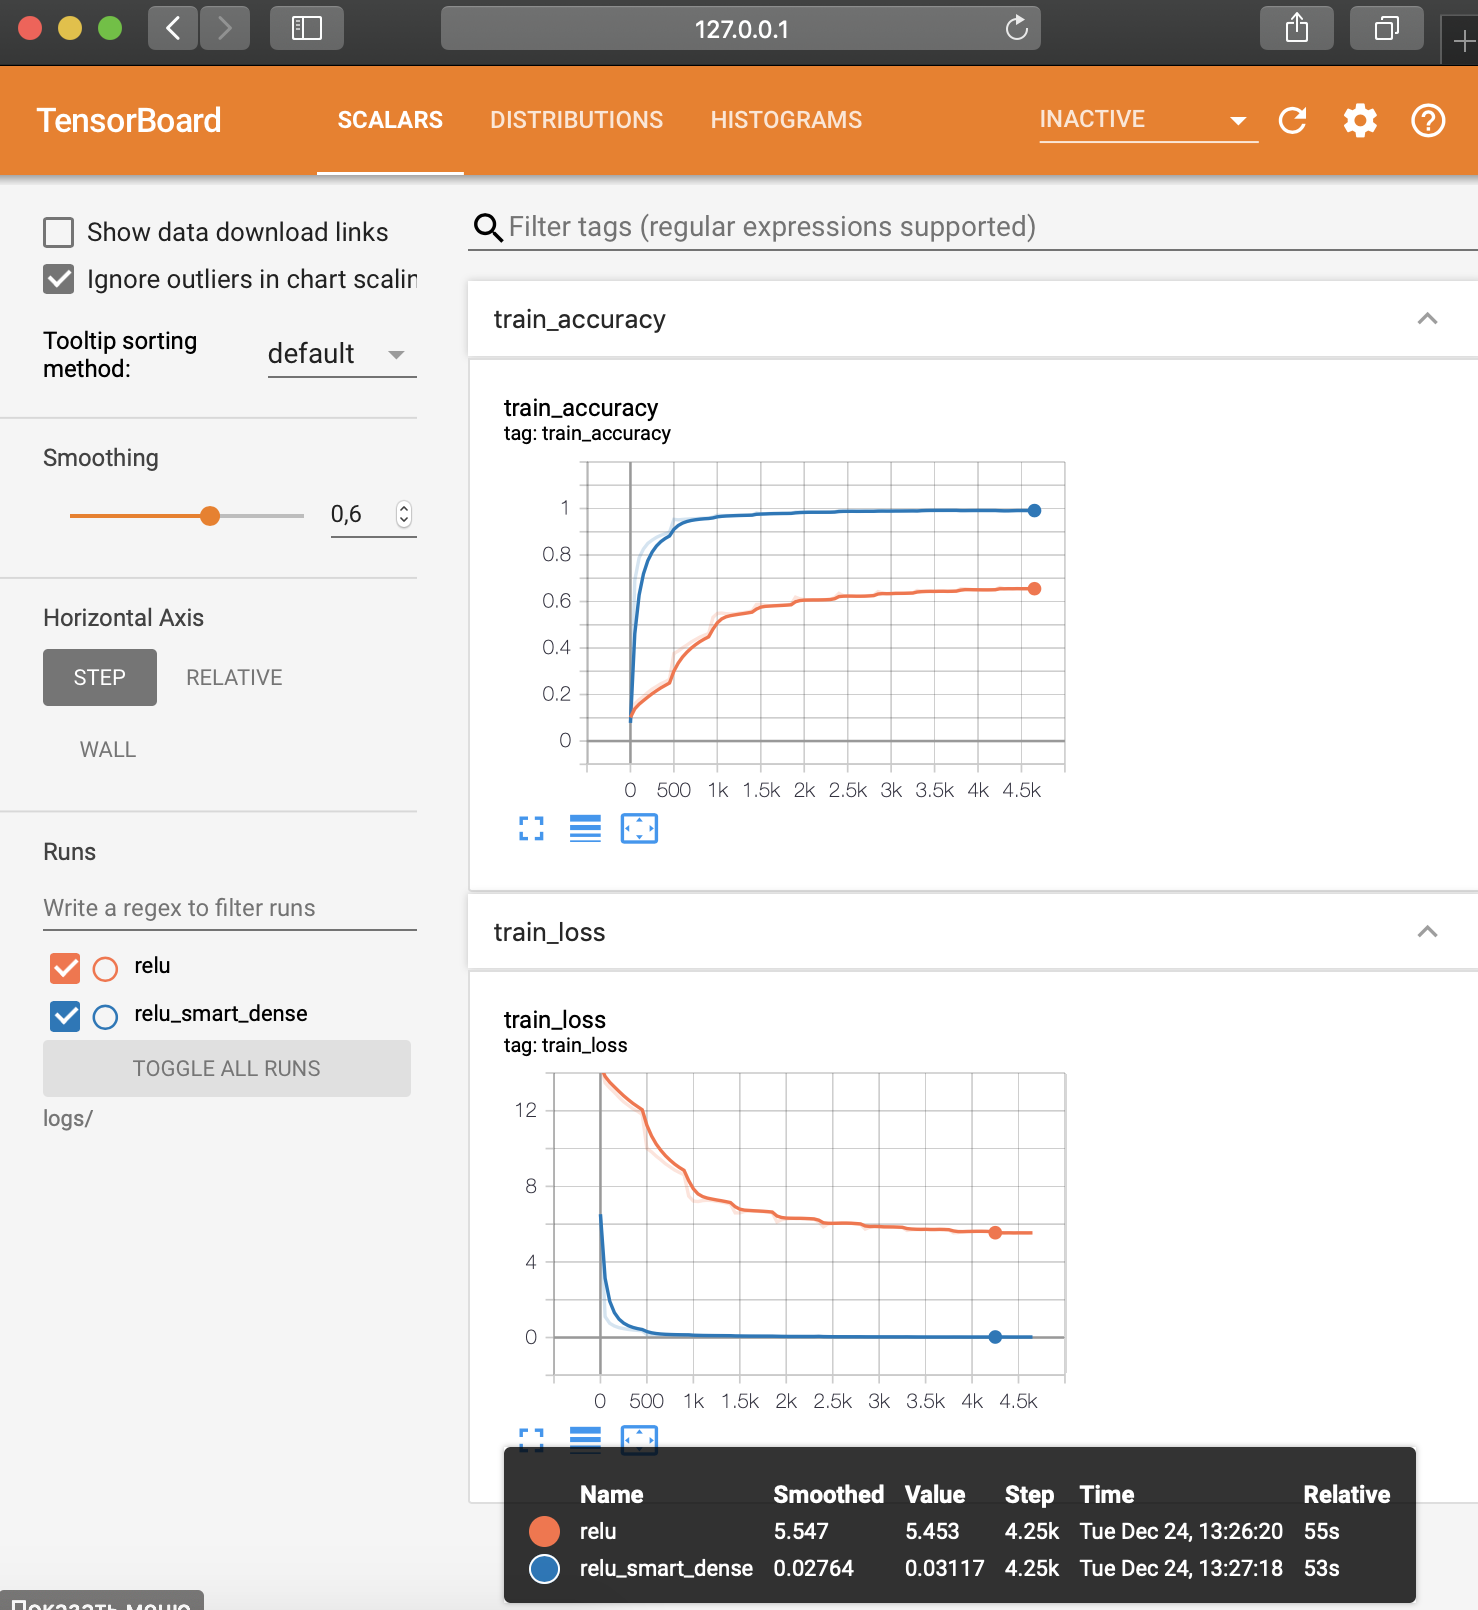

* `relu_smart_dense` достигает accuracy=1 быстрее `relu`; `relu` вообще не достигает 1, а выходит на плато~0.65.
* Также `relu_smart_dense` изначально принимает loss, меньший, чем у `relu`. Далее скорость ументшения loss у `relu_smart_dense` выше и приходит к 0 быстрее, при том, что `relu` имеет наилучший loss равный только лишь 5.5.

In [60]:
writer = tf.summary.create_file_writer("logs/relu")

model = Sequential(Dense(784, 100, tf.nn.relu, 'dense'), 
                   Dense(100, 100, tf.nn.relu, 'dense1'), 
                   Dense(100, 10, tf.nn.softmax, 'dense2'))

hist = model.fit_generator(train_seq, test_seq, 10,
                           keras.losses.sparse_categorical_crossentropy, 
                           keras.optimizers.Adam(),
                           writer)

Epoch 1: Train loss: 12.108 Train Accuracy: 0.247
Epoch 1: Val loss: 11.170 Val Accuracy: 0.306
********************
Epoch 2: Train loss: 10.099 Train Accuracy: 0.372
Epoch 2: Val loss: 8.734 Val Accuracy: 0.456
********************
Epoch 3: Train loss: 8.398 Train Accuracy: 0.477
Epoch 3: Val loss: 7.529 Val Accuracy: 0.531
********************
Epoch 4: Train loss: 7.249 Train Accuracy: 0.548
Epoch 4: Val loss: 6.957 Val Accuracy: 0.567
********************
Epoch 5: Train loss: 6.988 Train Accuracy: 0.565
Epoch 5: Val loss: 6.841 Val Accuracy: 0.575
********************
Epoch 6: Train loss: 6.895 Train Accuracy: 0.571
Epoch 6: Val loss: 6.827 Val Accuracy: 0.575
********************
Epoch 7: Train loss: 6.876 Train Accuracy: 0.573
Epoch 7: Val loss: 6.797 Val Accuracy: 0.577
********************
Epoch 8: Train loss: 6.768 Train Accuracy: 0.579
Epoch 8: Val loss: 6.720 Val Accuracy: 0.583
********************
Epoch 9: Train loss: 6.759 Train Accuracy: 0.580
Epoch 9: Val loss: 6.690 Val

In [66]:
writer = tf.summary.create_file_writer("logs/relu_smart_dense")

model = Sequential(DenseSmart(784, 100, tf.nn.relu, 'dense'), 
                   DenseSmart(100, 100, tf.nn.relu, 'dense1'), 
                   DenseSmart(100, 10, tf.nn.softmax, 'dense2'))

hist = model.fit_generator(train_seq, test_seq, 10,
                           keras.losses.sparse_categorical_crossentropy, 
                           keras.optimizers.Adam(),
                           writer)

Epoch 1: Train loss: 0.358 Train Accuracy: 0.896
Epoch 1: Val loss: 0.167 Val Accuracy: 0.949
********************
Epoch 2: Train loss: 0.131 Train Accuracy: 0.961
Epoch 2: Val loss: 0.131 Val Accuracy: 0.959
********************
Epoch 3: Train loss: 0.090 Train Accuracy: 0.973
Epoch 3: Val loss: 0.117 Val Accuracy: 0.964
********************
Epoch 4: Train loss: 0.066 Train Accuracy: 0.980
Epoch 4: Val loss: 0.116 Val Accuracy: 0.965
********************
Epoch 5: Train loss: 0.052 Train Accuracy: 0.985
Epoch 5: Val loss: 0.113 Val Accuracy: 0.967
********************
Epoch 6: Train loss: 0.041 Train Accuracy: 0.987
Epoch 6: Val loss: 0.119 Val Accuracy: 0.967
********************
Epoch 7: Train loss: 0.035 Train Accuracy: 0.989
Epoch 7: Val loss: 0.115 Val Accuracy: 0.969
********************
Epoch 8: Train loss: 0.027 Train Accuracy: 0.991
Epoch 8: Val loss: 0.109 Val Accuracy: 0.972
********************
Epoch 9: Train loss: 0.024 Train Accuracy: 0.993
Epoch 9: Val loss: 0.114 Val Ac

## 3.a Испорченный батч-норм 

Запустите два эксперимент ниже. 

Почему обучение не идет? В чем ошибка в слое `BatchNorm`? Изучите и исправьте код метода `__call__` (Шаблон находится ниже под блоком с экспериментом.).

Можно пользоваться tensorboard, если он нужен.

## ReLU + Batch Norm

In [47]:
writer = tf.summary.create_file_writer("logs/relu_bn")

model = Sequential(Dense(784, 100, tf.nn.relu, 'dense'), 
                   BatchNormFlawed('batch_norm'), 
                   Dense(100, 100, tf.nn.relu, 'dense1'), 
                   Dense(100, 10, tf.nn.softmax, 'dense2'))

hist = model.fit_generator(train_seq, test_seq, 10,
                           keras.losses.sparse_categorical_crossentropy, 
                           keras.optimizers.Adam(),
                           writer)

Epoch 1: Train loss: nan Train Accuracy: 0.104
Epoch 1: Val loss: nan Val Accuracy: 0.098
********************
Epoch 2: Train loss: nan Train Accuracy: 0.099
Epoch 2: Val loss: nan Val Accuracy: 0.098
********************
Epoch 3: Train loss: nan Train Accuracy: 0.099
Epoch 3: Val loss: nan Val Accuracy: 0.098
********************
Epoch 4: Train loss: nan Train Accuracy: 0.099
Epoch 4: Val loss: nan Val Accuracy: 0.098
********************
Epoch 5: Train loss: nan Train Accuracy: 0.099
Epoch 5: Val loss: nan Val Accuracy: 0.098
********************
Epoch 6: Train loss: nan Train Accuracy: 0.099
Epoch 6: Val loss: nan Val Accuracy: 0.098
********************
Epoch 7: Train loss: nan Train Accuracy: 0.099
Epoch 7: Val loss: nan Val Accuracy: 0.098
********************
Epoch 8: Train loss: nan Train Accuracy: 0.099
Epoch 8: Val loss: nan Val Accuracy: 0.098
********************
Epoch 9: Train loss: nan Train Accuracy: 0.099
Epoch 9: Val loss: nan Val Accuracy: 0.098
********************
E

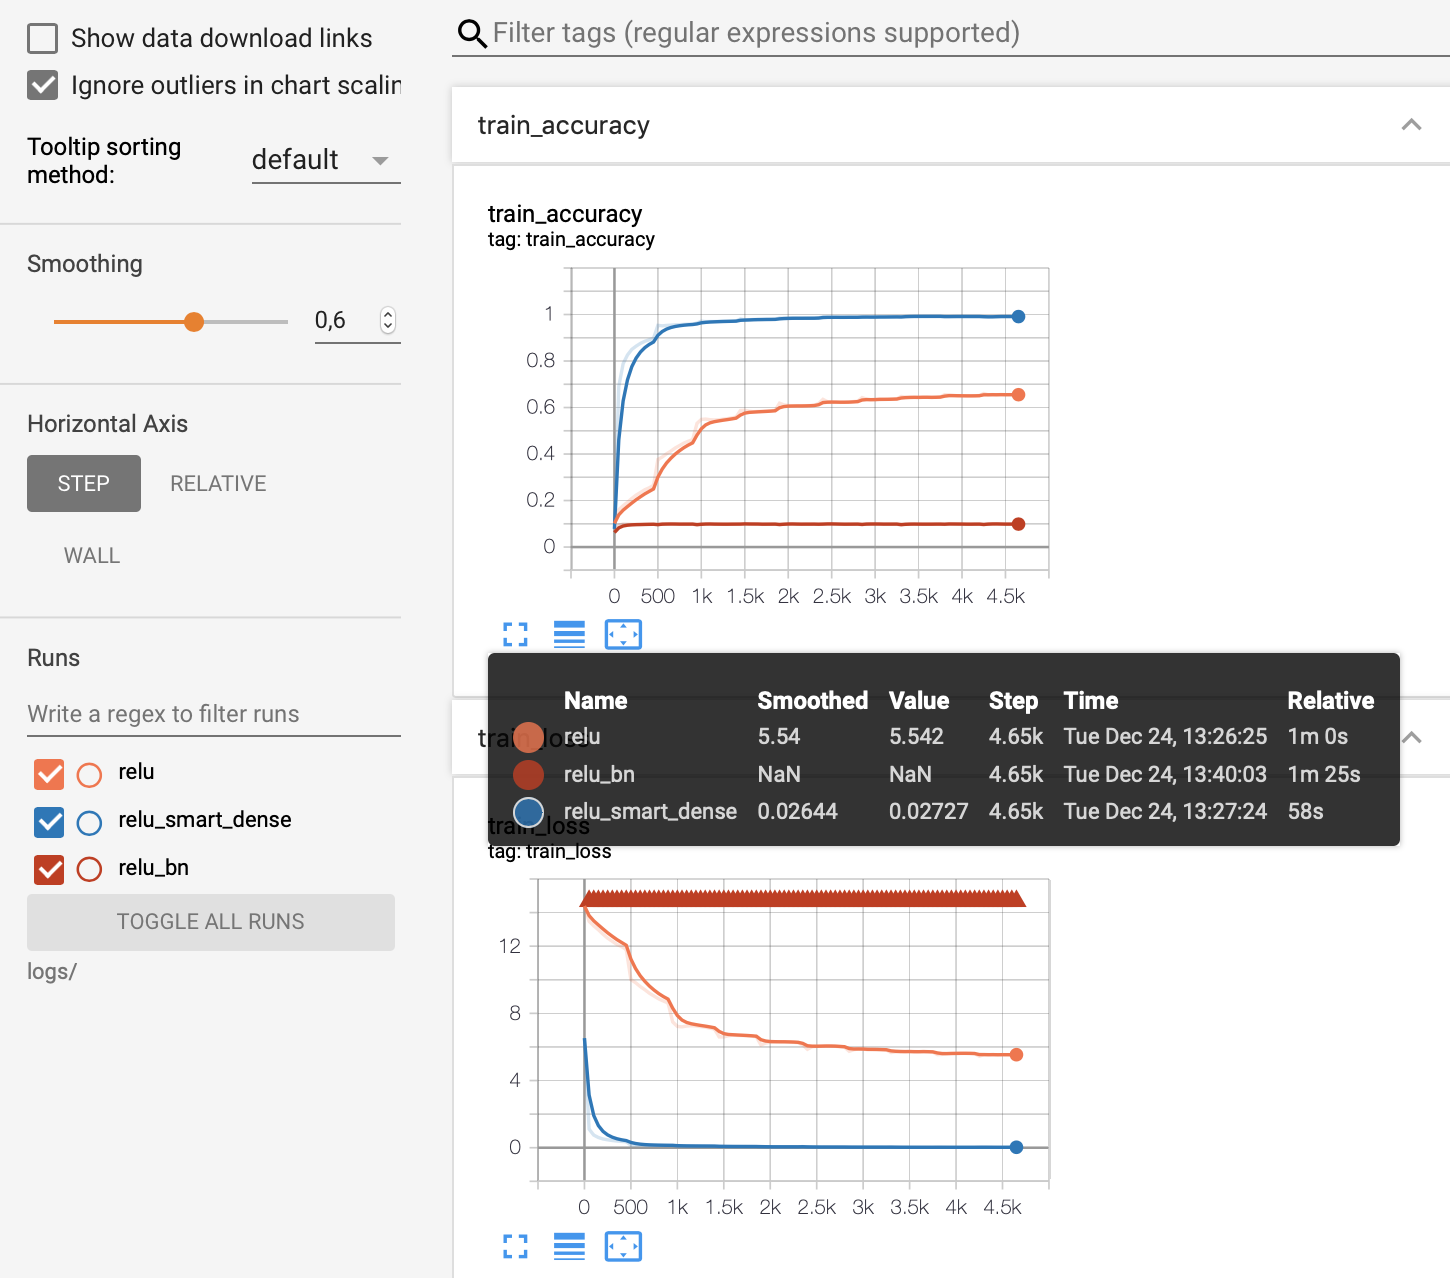

Действительно обучения не происходит - значения lossи accuracy остаются на 0.
<br><br>Для номрализации батча в статье
<br>Sergey Ioffe & Christian Szegedy: Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift [https://arxiv.org/pdf/1502.03167v3.pdf]
<br>используют стандартную формулу для номрализации значения "минус среднее и поделить на корень из дисперсии", но поскольку дисперсия может в какой-то момент принять 0, то такая формула "ломается" и выдает `NaN`.
<br><br>Для предотвращения этого я воспользовалась добалением пренибрежимо малой величиной $\epsilon = 1e-8$ , значение которой взяла из статьи 
<br>[https://towardsdatascience.com/understanding-batch-normalization-with-examples-in-numpy-and-tensorflow-with-interactive-code-7f59bb126642]:
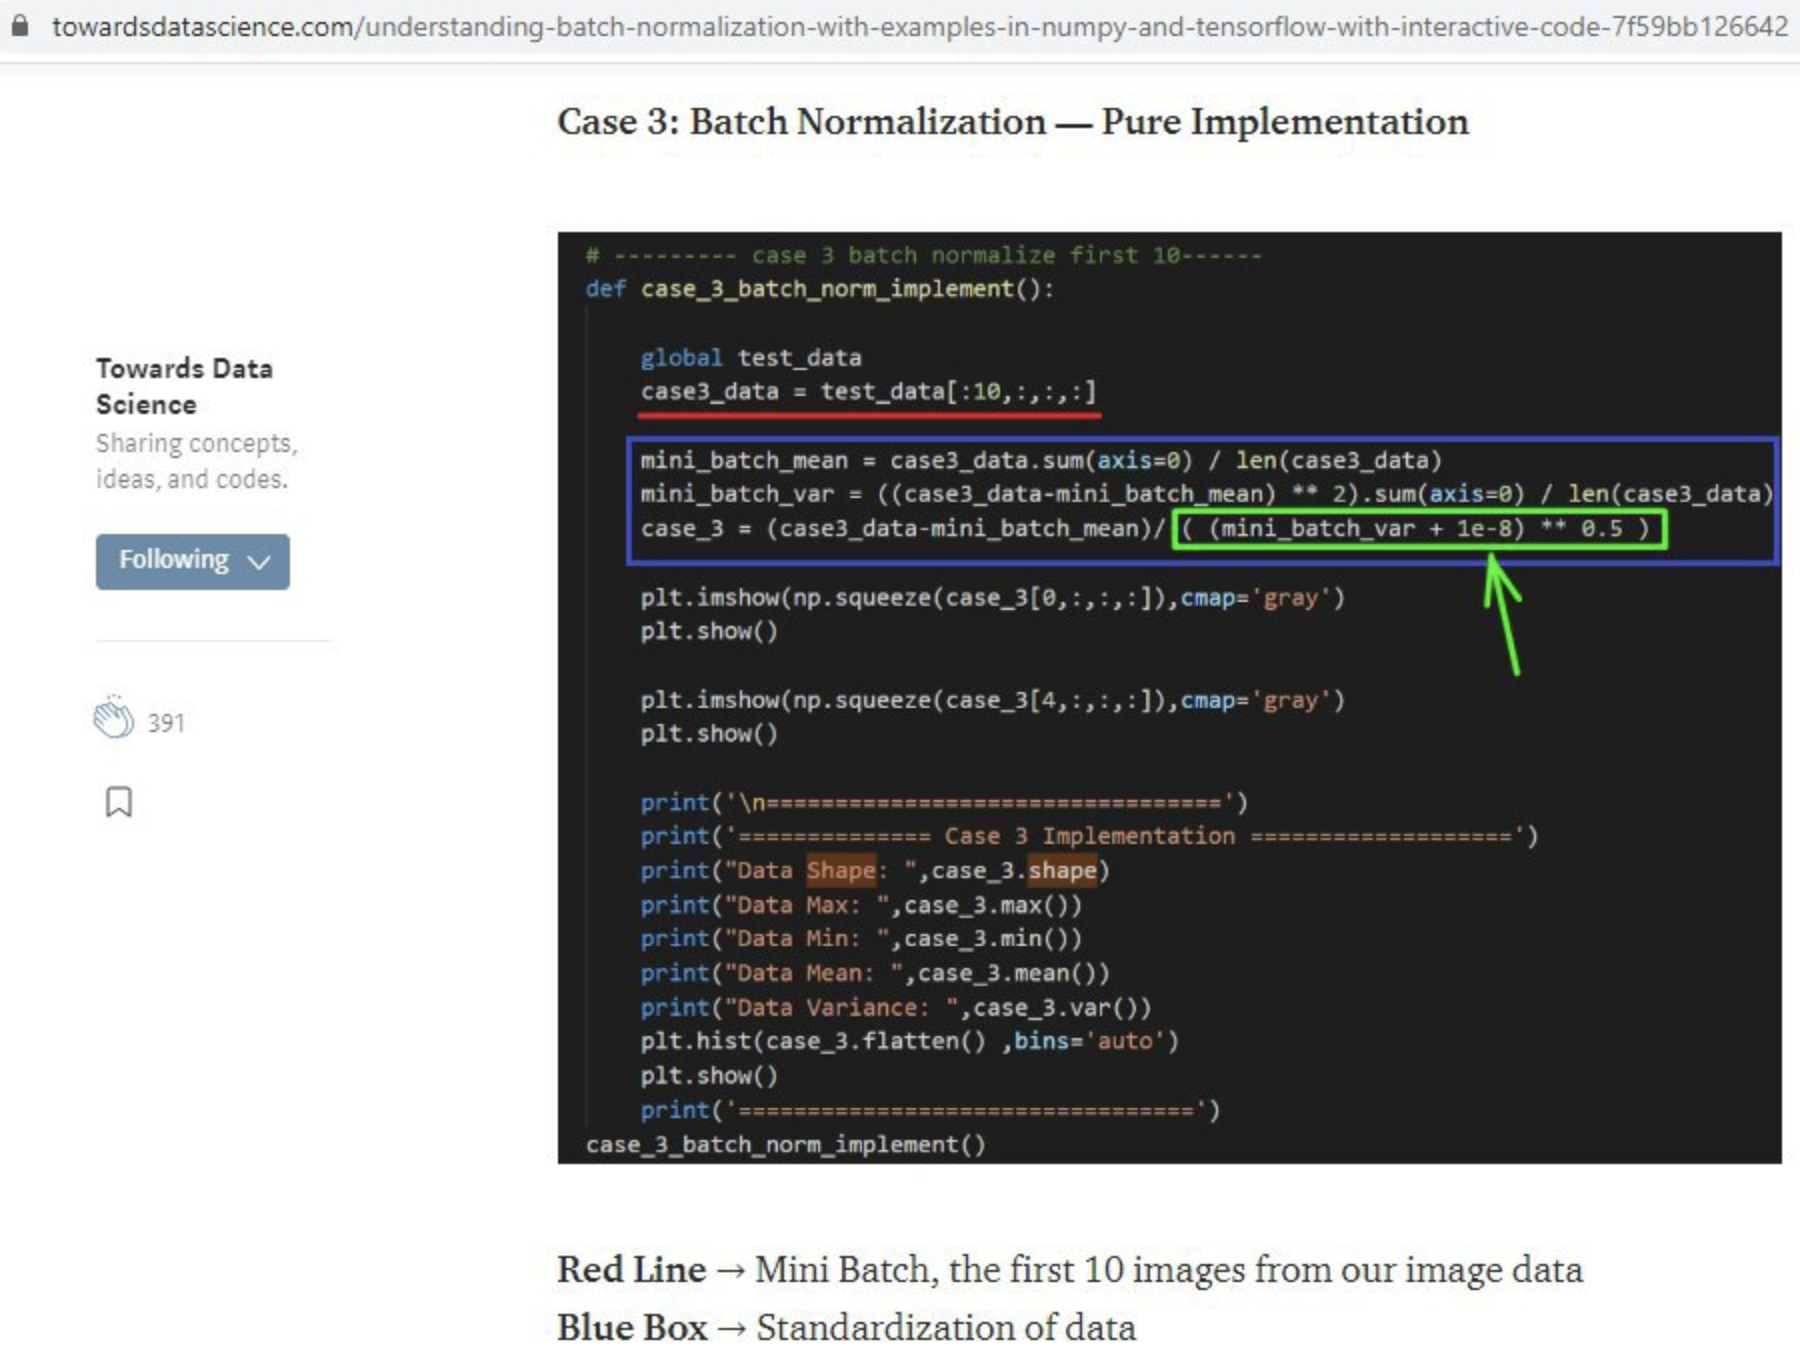

**Класс, который нужно исправить**

In [50]:
class BatchNormFixed(BatchNormFlawed):
    def __call__(self, x, writer=None, step=None):
        """
        Исправьте блок кода ниже так, чтобы модель обучалась, не появлялись значения loss = NaN        """
        mu = tf.reduce_mean(x, axis=0)
        sigma = tf.math.reduce_std(x, axis=0)
        normed = (x - mu) / (sigma**2 + 1e-8)**0.5 # добавила погрешность=1e-8, чтобы не происходило деления на 0
        out = normed * self._gamma + self._beta
        """
        Конец блока, который нужно исправить
        """
        
        if writer is not None:
            with writer.as_default():
                tf.summary.histogram(self.name + '_beta', self._beta, step=step)
                tf.summary.histogram(self.name + '_gamma', self._gamma, step=step)
                tf.summary.histogram(self.name + '_normed', normed, step=step)
                tf.summary.histogram(self.name + '_out', out, step=step)
                tf.summary.histogram(self.name + '_sigma', sigma, step=step)
                tf.summary.histogram(self.name + '_mu', mu, step=step)
        return out

## 3.b Исправленный батч-норм 

Запустите эксперимент ниже. 

Обучается ли сеть? Идет ли процесс обучения лучше, чем в эксперименте с ReLU? 

Сравните обучение сетей c ReLU и слоем `Dense` (а не `DenseSmart`!) и ReLU с BatchNorm в tensorboard, как в задании 2.
Напишите ваши выводы.

_Обратите внимание, что слева в интерфейсе tensorboard есть меню, которое позволяет выключать визуализацию ненужных экспериментов._

**Ваш комментарий:**



---------


In [61]:
writer = tf.summary.create_file_writer("logs/relu_bn_fixed")

model = Sequential(Dense(784, 100, tf.nn.relu, 'dense'), 
                   BatchNormFixed('batch_norm'), 
                   Dense(100, 100, tf.nn.relu, 'dense1'), 
                   Dense(100, 10, tf.nn.softmax, 'dense2'))

hist = model.fit_generator(train_seq, test_seq, 10,
                           keras.losses.sparse_categorical_crossentropy, 
                           keras.optimizers.Adam(),
                           writer)

Epoch 1: Train loss: 9.550 Train Accuracy: 0.380
Epoch 1: Val loss: 5.812 Val Accuracy: 0.606
********************
Epoch 2: Train loss: 2.634 Train Accuracy: 0.677
Epoch 2: Val loss: 0.743 Val Accuracy: 0.769
********************
Epoch 3: Train loss: 0.631 Train Accuracy: 0.804
Epoch 3: Val loss: 0.536 Val Accuracy: 0.837
********************
Epoch 4: Train loss: 0.491 Train Accuracy: 0.849
Epoch 4: Val loss: 0.442 Val Accuracy: 0.869
********************
Epoch 5: Train loss: 0.410 Train Accuracy: 0.875
Epoch 5: Val loss: 0.383 Val Accuracy: 0.887
********************
Epoch 6: Train loss: 0.354 Train Accuracy: 0.893
Epoch 6: Val loss: 0.339 Val Accuracy: 0.900
********************
Epoch 7: Train loss: 0.311 Train Accuracy: 0.906
Epoch 7: Val loss: 0.305 Val Accuracy: 0.910
********************
Epoch 8: Train loss: 0.276 Train Accuracy: 0.917
Epoch 8: Val loss: 0.277 Val Accuracy: 0.918
********************
Epoch 9: Train loss: 0.247 Train Accuracy: 0.925
Epoch 9: Val loss: 0.253 Val Ac

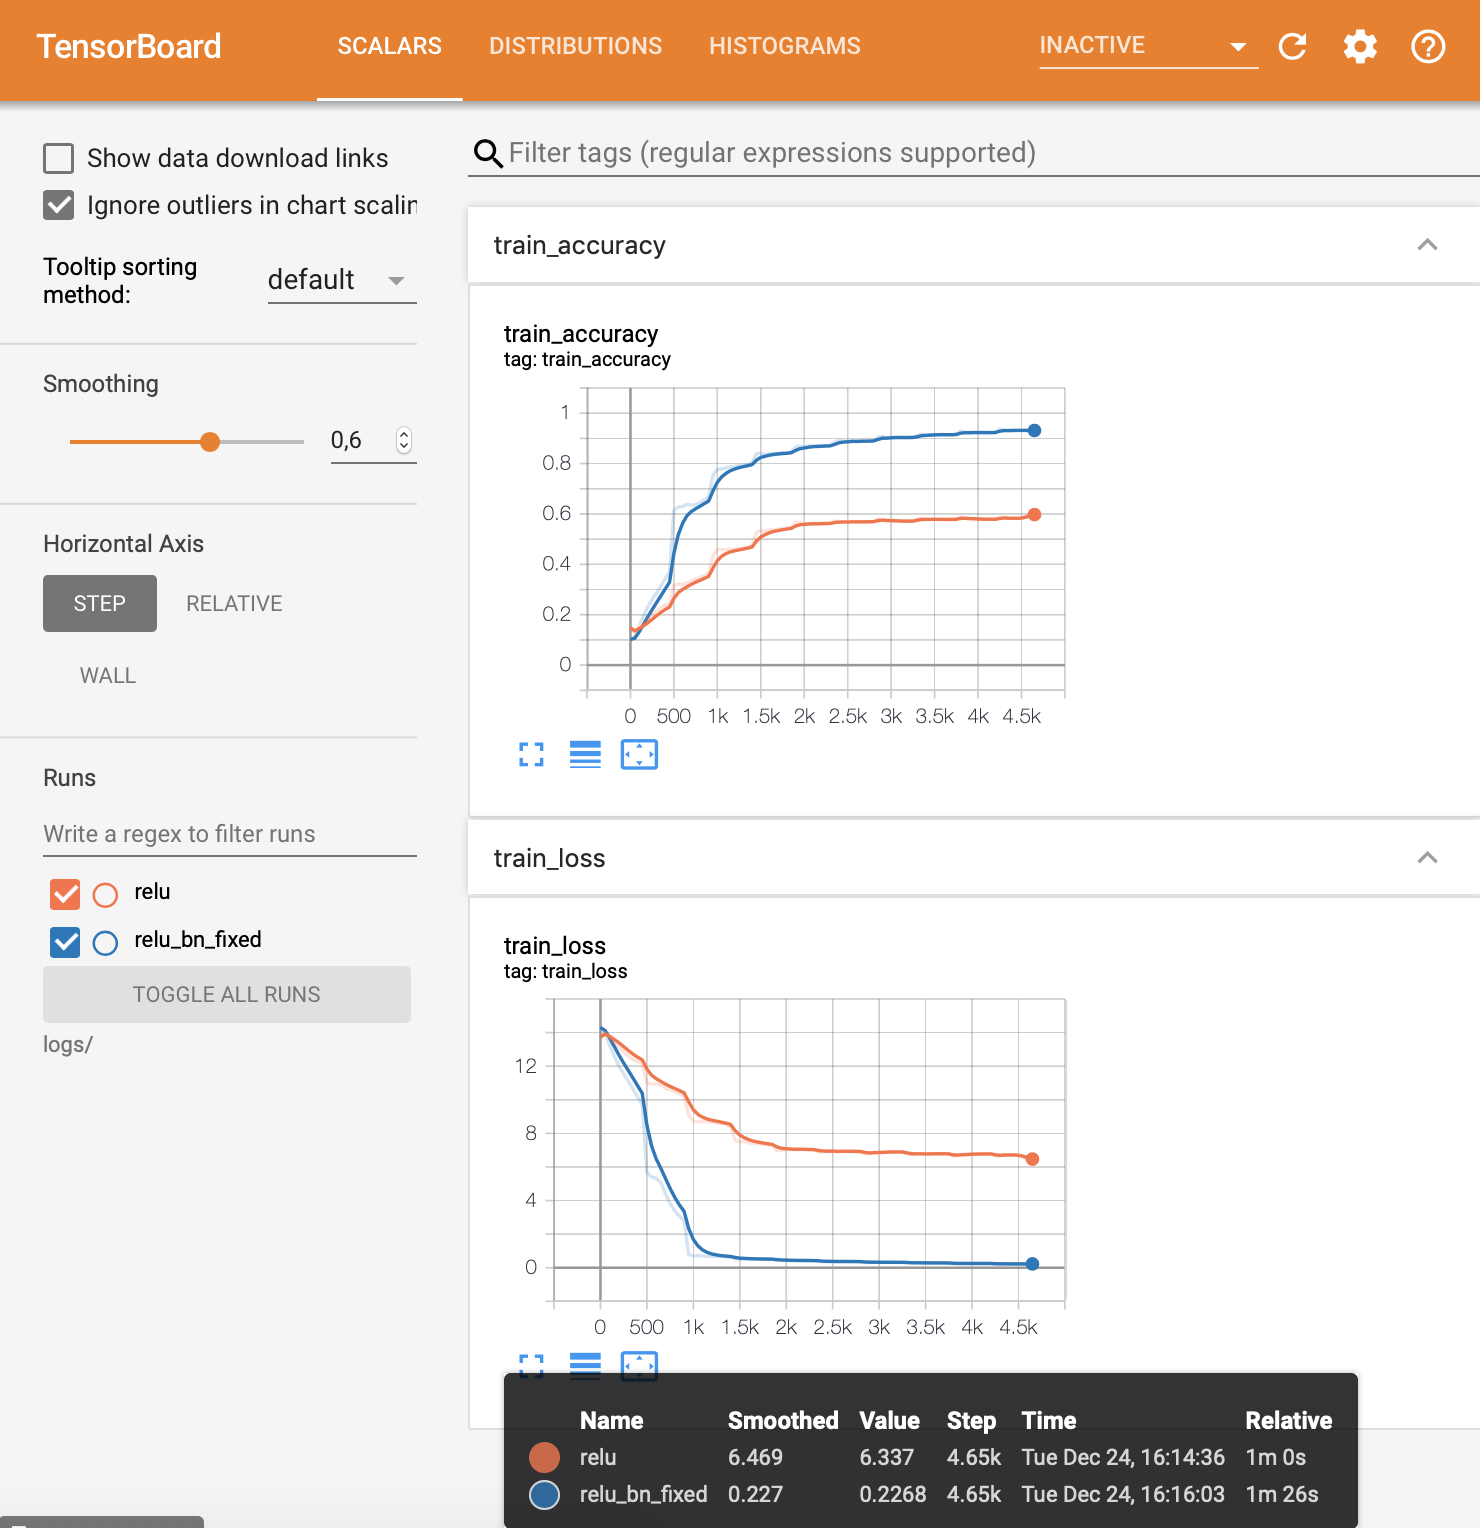

После добаления $\epsilon$ сеть начала учиться.
<br>В сравнении с `RelU+Dense` `ReLu+BatchNorm` обучается быстрее - уменьшает loss быстрее. А также использвоание BatchNorm позваоляет повысить финальное значение accuracy чуть ли не в 2 раза по сравнению просто с `ReLu`.

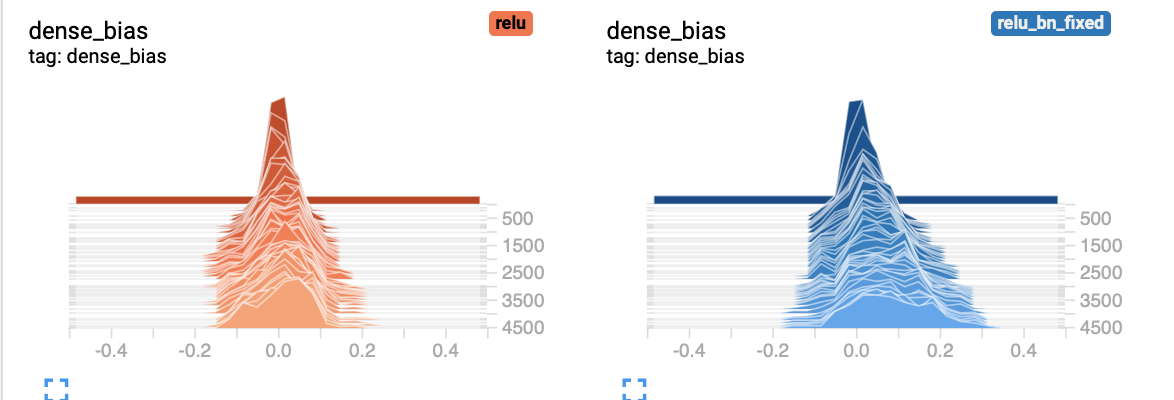

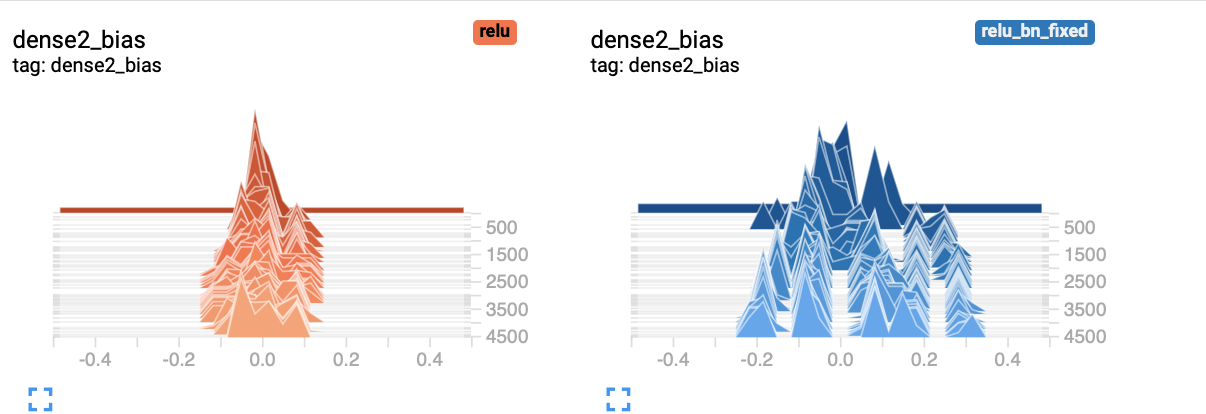

Значения bias (ошибки/шума) после слоя 2 для `ReLu+BatchNorm` становятся более распределенными/разрозненными, по сравнению с `ReLu`, где шум группироуется вокруг 0, искажая (добавляя большей погрешности) для значений z слоя.

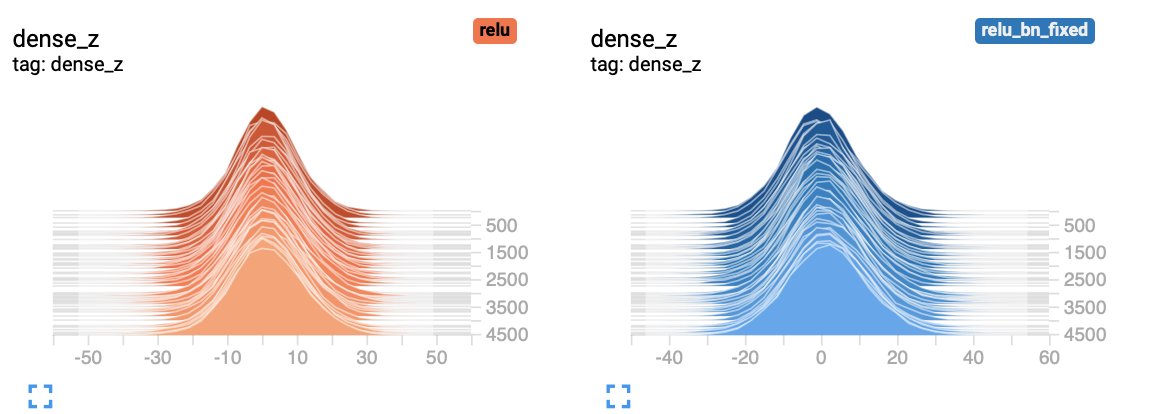

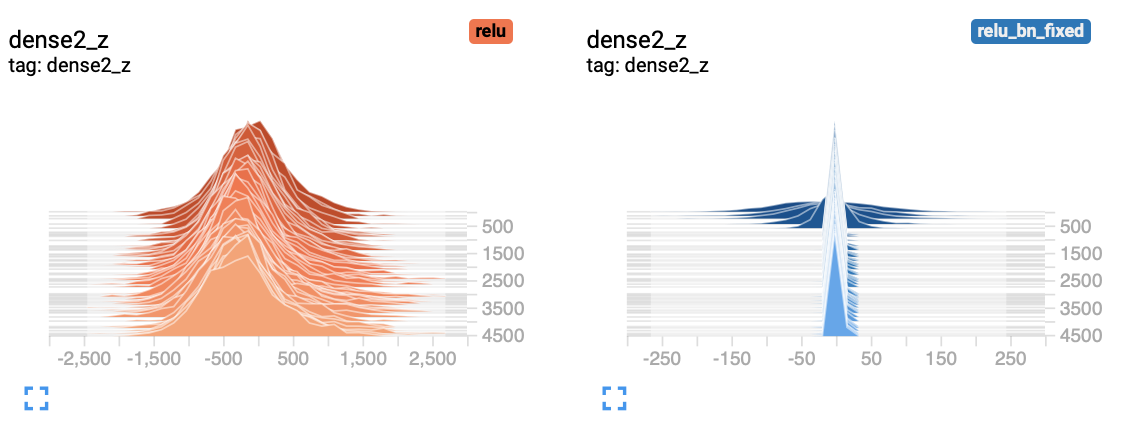

Выходные значения после слоя 2 принимают форму пиков для `ReLu+BatchNorm`, по сравнению с `ReLu`.

## 4. "Сырые" данные. 

Что будет, если заставить сеть обучаться на сырых данных? 

Напишите такую функцию `preprocess`, которая не делает min-max scaling изображений и оставляет их в изначальном диапазоне. Не убирайте reshape! Конечно, она должна менять форму матрицы входных данных от `(n x 28 x 28)` к `(n x 784)`. 

Затем передайте функцию в MNISTSequence, создайте новую train- и test- последовательности запустите эксперимент, используя их как входные данные. 

Сравните результаты экспериментов c `DenseSmart` + ReLU и обработанными изображениями и `DenseSmart` + ReLU c необработанными изображениями. 

Обучается ли нейросеть? Если нет, то почему? Сделайте выводы, как в задании 2.

**Ваш комментарий:**



---------


**Шаблон Preprocess**

In [64]:
def preprocess(X, y):
    """
    Ваш код
    """
    X = X.reshape((-1, 28*28))  # добавленный код
    y = y  # добавленный код
    return X, y

**Создание генераторов**

In [65]:
train_seq_raw = MNISTSequence(X_tr, y_tr, 128, preprocess=preprocess)
test_seq_raw = MNISTSequence(X_test, y_test, 128, preprocess=preprocess)

**Эксперимент**

In [67]:
writer = tf.summary.create_file_writer("logs/raw")

model = Sequential(DenseSmart(784, 100, tf.nn.relu, 'dense'), 
                   DenseSmart(100, 100, tf.nn.relu, 'dense1'), 
                   DenseSmart(100, 10, tf.nn.softmax, 'dense2'))

hist = model.fit_generator(train_seq_raw, test_seq_raw, 10,
                           keras.losses.sparse_categorical_crossentropy, 
                           keras.optimizers.Adam(),
                           writer
                          )

Epoch 1: Train loss: 14.514 Train Accuracy: 0.100
Epoch 1: Val loss: 14.310 Val Accuracy: 0.112
********************
Epoch 2: Train loss: 13.558 Train Accuracy: 0.159
Epoch 2: Val loss: 13.159 Val Accuracy: 0.184
********************
Epoch 3: Train loss: 13.279 Train Accuracy: 0.176
Epoch 3: Val loss: 13.028 Val Accuracy: 0.192
********************
Epoch 4: Train loss: 13.121 Train Accuracy: 0.186
Epoch 4: Val loss: 12.970 Val Accuracy: 0.195
********************
Epoch 5: Train loss: 13.021 Train Accuracy: 0.192
Epoch 5: Val loss: 12.998 Val Accuracy: 0.193
********************
Epoch 6: Train loss: 13.251 Train Accuracy: 0.178
Epoch 6: Val loss: 13.028 Val Accuracy: 0.192
********************
Epoch 7: Train loss: 13.066 Train Accuracy: 0.189
Epoch 7: Val loss: 13.031 Val Accuracy: 0.191
********************
Epoch 8: Train loss: 13.066 Train Accuracy: 0.189
Epoch 8: Val loss: 13.031 Val Accuracy: 0.191
********************
Epoch 9: Train loss: 13.066 Train Accuracy: 0.189
Epoch 9: Val l

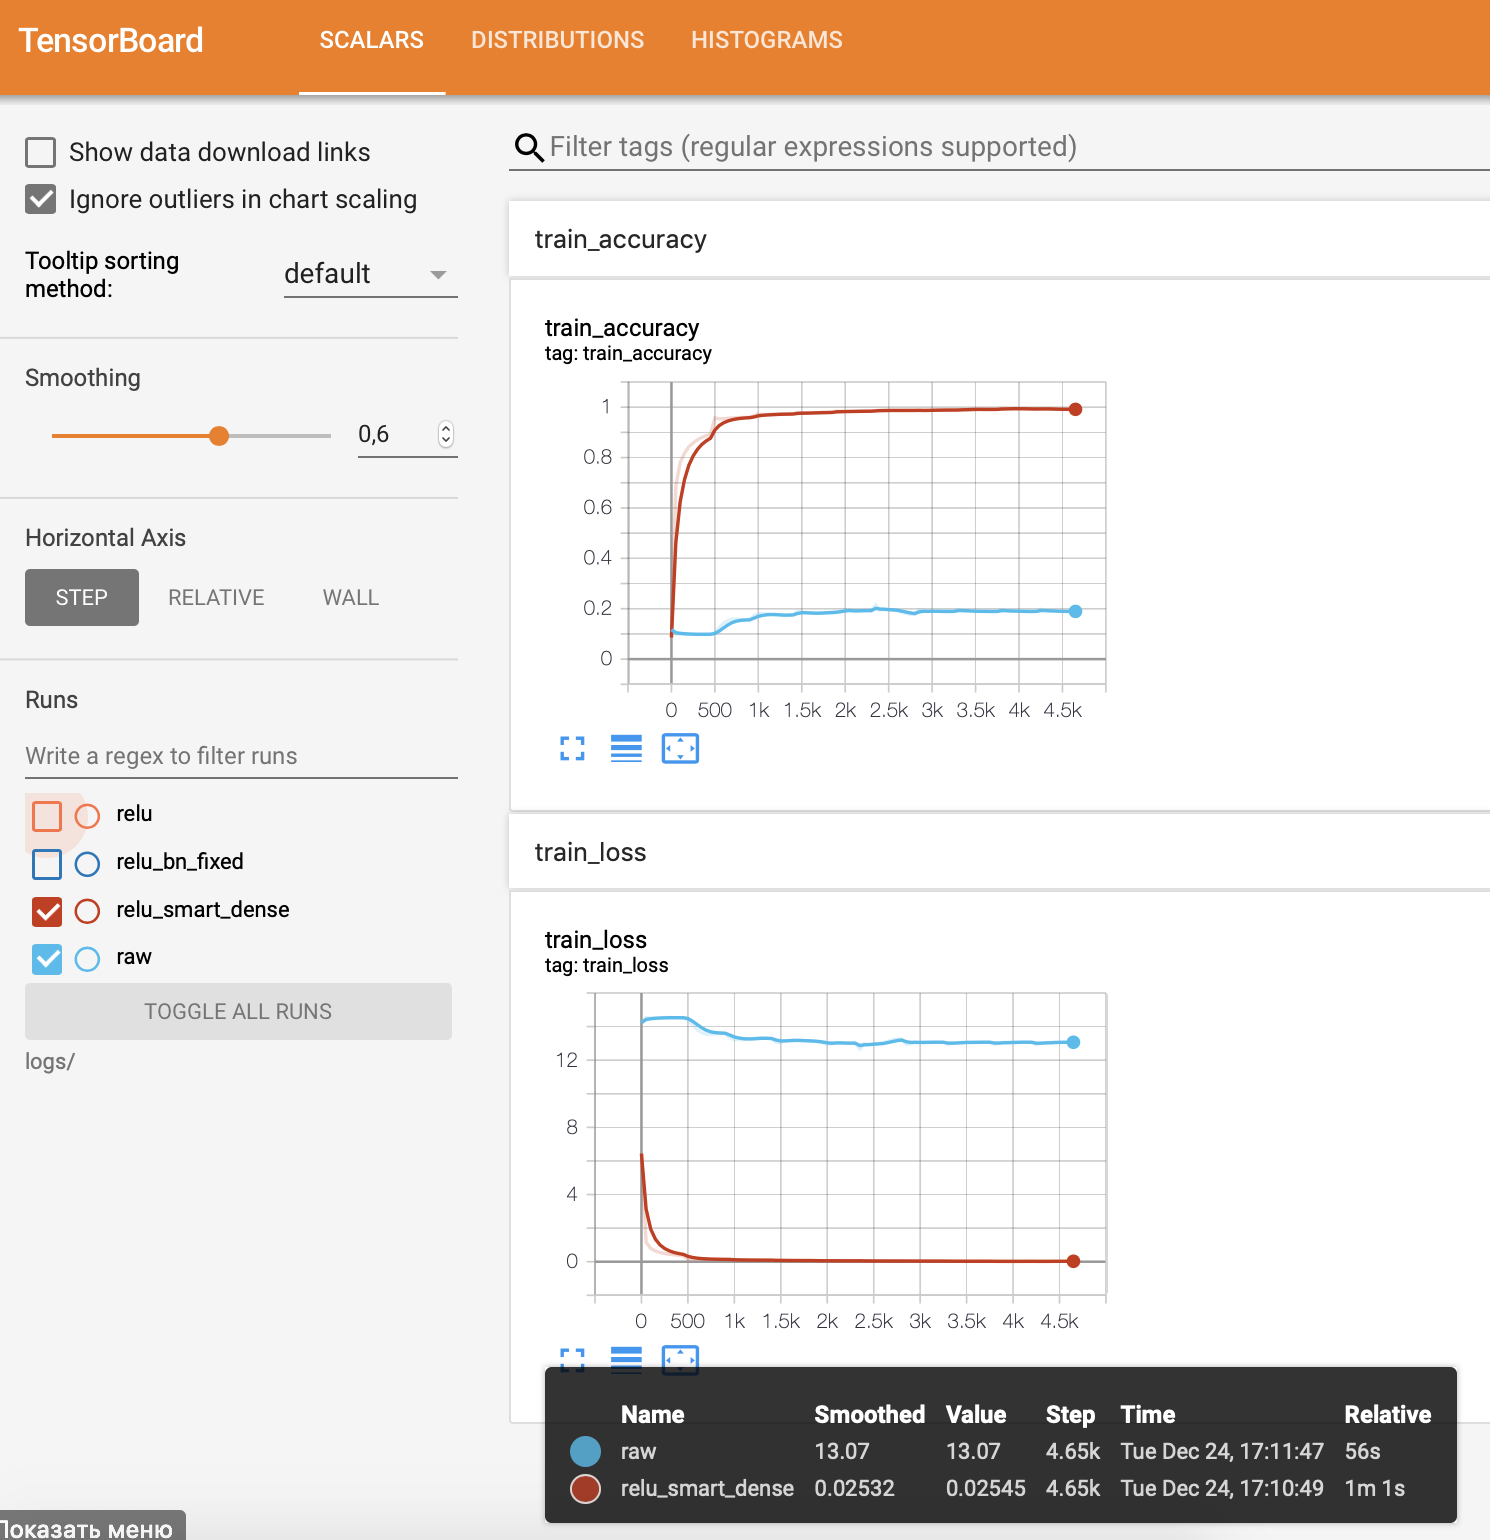

В общем accuracy для ненормализованных данных принимает максимум 0.2, для нормализованных данных - 1.0
<br>Грубо говоря, сеть для данных без нормализации по min-max не обучается (или начинает "обучаться" только после 500-го шага, когда сеть с нормализованными данными уже обучилась, тем не менее не принимая адекватного значения accuracy/loss)